# *Deep Learning on LandCover.ai dataset*

<br>

#### Christos Nikou - MSc Student in Data Science & Machine Learning (NTUA)
#### Email: chrisnick92@gmail.com / christosnikou@mail.ntua.gr
#### [GitHub](https://github.com/ChrisNick92) repo in Geospatial Big data Analytics

<b>*Note*</b> This notebook was developed for the purposes of a lab exercise in the course of Geospatial Big Data Analytics during my Master's degree in Data Science & Machine Learning in National Technical University of Athens.

# Short Description <a name="description"></a>

In this lab exercise the task is to make use of the deep learning techniques and develop an architecture in order to provide an approach into solving a problem related to Earth observation. Each student had the ability to choose a specific task and a design algorithm from a predefined list given by the instructors of the course. In this lab we explore the semantic segmentation task of high resolution images provided by aerial systems. In particular, we are interested in providing a fast and efficient solution to the annotation of different land uses by exploiting the aerial images and the techniques of deep learning.

The computational resources as well as the sophisticated algorithms that have been developed over the past years, have given the opportunity to detect and provide efficient land coverage annotation in matter of few minutes or seconds as opposed to the previous years. With the advent of neural networks and especially the CNNs all the burden of mannually crafting feature extractors and rules has been replaced by automatic procedures. The focus now is on the development of efficient architectures that can provide fast and accurate solutions. 

For this purpose, we develop different architectures in order to find the best model for detecting 5 land uses: 1) buildings, 2) woodlands, 3) water 4) roads and 5) background. The dataset that we use in this lab is the [LandCover.ai](#https://landcover.ai.linuxpolska.com) which can be found also in Kaggle through this [link](#https://www.kaggle.com/datasets/adrianboguszewski/landcoverai). The challenge when working with high resolution images is that in order to capture as many as possible instances from each land area you need to work with larger images (with respect to height and width). This fact makes harder to train deep learning models since the computational resources required rise quickly. 

# 1. Data description & preparation <a name="1"></a>

## 1.1 Data Visualizations <a name="1.1"></a>

The dataset that we utilize in this notebook is the LandCover.ai as presented in [[1]](#ref1). The dataset consists of 41 orthophoto tiles from different counties located in Poland. Every tile has about 5 km$^2$. There are 33 images with resolution 25 cm (ca. 9000 x 9500 px) and 8 images with resolution 50 cm (ca. 4200 x 4700 px), which gives 176.76 km$^2$ and 39.51 km$^2$ respectively resutling in 216.27 km$^2$ coverage in total. Below you can see some samples from the dataset.

In [1]:
import shutil
import os

# Define the source and destination
source_dir = "../input/"
output_zip = "/kaggle/working/all_datasets.zip"

# Zip the entire input folder
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_dir)

# Optional: Download the zip file
from IPython.display import FileLink
FileLink(output_zip)

/kaggle/working/all_datasets.zip

In [2]:
from IPython.display import FileLink
FileLink("/kaggle/working/all_datasets.zip")

/kaggle/working/all_datasets.zip

In [2]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

DATA_ROOT = "../input/landcoverai"

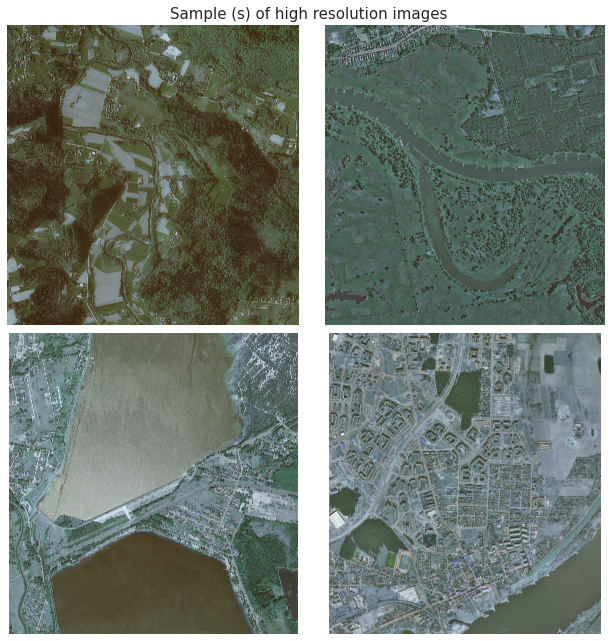

In [3]:
images_list = list(glob.glob(os.path.join(DATA_ROOT, "images", "*.tif")))
samples = [0,1,2,3]
fig, ax = plt.subplots(figsize = (9,9), nrows = 2, ncols =2)
for i, sample in enumerate(samples):
    r,c = divmod(i,2)
    ax[r,c].imshow(cv2.imread(images_list[sample])/255)
    ax[r,c].axis("off")
plt.suptitle("Sample (s) of high resolution images", fontsize = 15)
plt.tight_layout(pad=0.8)
plt.savefig("Samples.png")
plt.show()

The annotations of the dataset have been manually created with the VGG Image Annotator (VIA) [[2]](#ref2). The creators of the dataset provide the corresponding masks for the images. There are 5 classes in total:

<h4><center>The different land uses of the dataset</center></h4>

| **Class** | **Coverage (km$^2$)** | **Label** |
|:---------------|:-----------------|:-----------------|
| **Background** |       **125.75**     |       **0**     |
| **Building** |       **1.85**     |       **1**     |
| **Woodland** |       **72.02**     |       **2**     |
| **Water** |       **13.15**     |       **3**     |
| **Road** |       **3.5**     |       **4**     |

To keep this notebook readable we create a utility scipt named *utils.py* that we keep all the necessary functions and classes that we will use throughout this notebook. Using the custom function `visualize_tif` we can see an RGB image with the corresponding masks. We use the same color map that the creators of this dataset used in order to visualize the 5 different land uses; i.e. buildings are dark gray, woodlands are middle gray, water  is light gray, roads are white, and the black pixels correspond to other land uses (background).

In [ ]:
"""from utils import visualize_tif

visualize_tif(h = 8, w = 8, index = 2,
             save_title = "VisualizeTif") # Index = n corresponds to the n-th tif file in order located in "images" file"""

## 1.2 Image Cropping <a name="1.2"></a>

The large size of the images (~ 9000 x 9000) is prohibitive in order to train a deep neural network. This mainly due to the limited GPU resources available. The authors in [[1]](#ref1) split the images and their corresponding masks into 512 x 512 tiles and they use the 70, 15, 15 % of them as training, validation and test sets. Moreover, they provide lists of filenames with the images contained in the all the aforementioned datasets. In this way, new users of the dataset will be able to test their models on the same sets and compare their results with the benchmark results.

We create a custom function named `split_images` to wrap the splitting module into a function. The only argument of the function is the size of the resulting squared images (default is set to 512). Below we split the images by using the custom function and save the results into a folder named output.

### 1.2.1 Squared images of size 512 <a name="1.2.1"></a>

In this subsection we split the images into smaller images of size 512x512. Furthermore, we provide some statistical properties of the resulting dataset. Below you can see some samples of the obtained dataset using the custom function `visualize_dataset`.

In [4]:
# Splitting the images
from utils import split_images

IMAGE_SIZE = 512
split_images(TARGET_SIZE = IMAGE_SIZE)

Splitting the images...

Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A

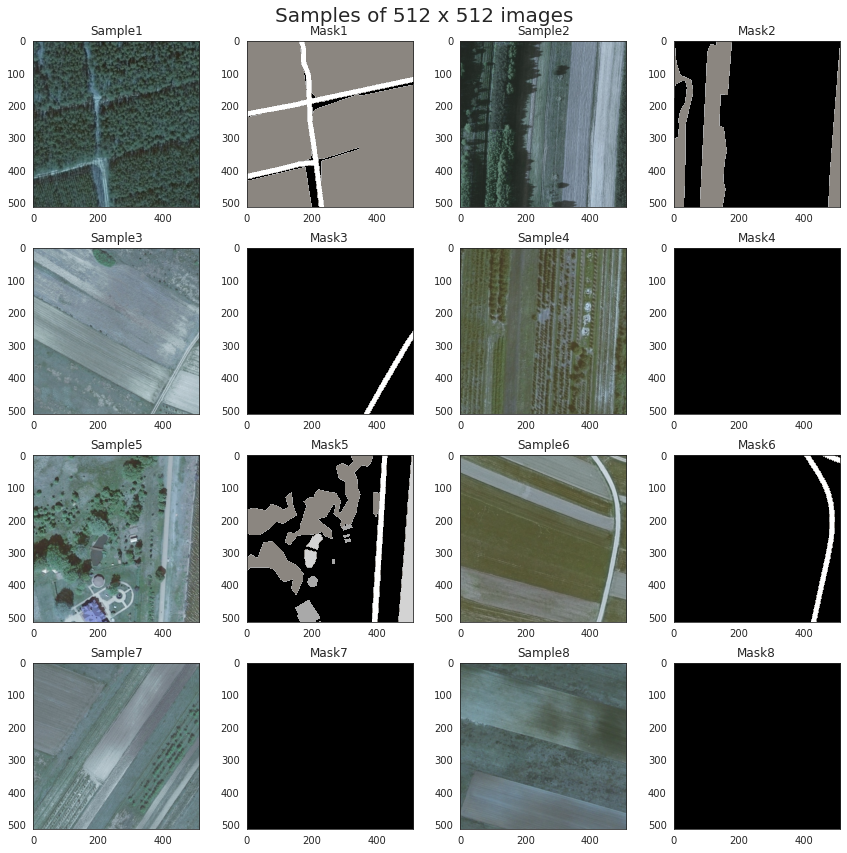

In [5]:
from utils import visualize_dataset

visualize_dataset(num_samples = 8, w = 12, h = 12, pad = 1.4,
                 save_title = "Visualize_dataset", indices = [0,1,17,20,29,5,6,7])

Since background covers about 125 km$^2$ and woodlands 72 km$^2$ we see that the dataset is highly unbalanced. As will shall shortly see the fact that background & woodland covers most of the pixels poses a great challenge to the development of a model that recognizes the other areas. In our cases, the hardest pixels to classify are the pixels corresponding to roads and buildings. To tackle this problem we develop several mechanisms, some of them have to do with the architecture of the model, the loss function or the chosen regularizations during the training procedure. 

Below you can see the exact pixels corresponding to each class for the training set in the case of the 512 x 512 images. In order to find the distribution of the training test we construct a custom class named `SegmentationDataset`. This class will be used also to train and validate the models in the next sections. It inherits from the `nn.Module`, the arguments is variable `mode` which corresponds to the txt file to be read, i.e. "train.txt", "val.txt", "test.txt". The argument `ratio` which corresponds to the total ratio of the given dataset (either train,val or test) to be used. For example, if `mode = "train"` and `ratio = 0.5` then the 50% of the whole training set will be used. The argumennt `transforms` which corresponds to the transformations that we will use in the next subsections to augment the training set for better performance.

In [6]:
import torch
from torch.utils.data import DataLoader
from utils import SegmentationDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set,batch_size = 8,num_workers =2)

class_dist = {"background":0, "building":0,
                     "woodland":0, "water":0, "road":0}
label_mapping = {0: "background", 1: "building",
                2: "woodland", 3: "water", 4: "road"}

for img,mask in train_dloader:
    for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

In [ ]:
temp_list = sorted([(l,s) for (l,s) in class_dist.items()], key= lambda x: x[1])
labels = [x[0] for x in temp_list]
support = [x[1] for x in temp_list]

sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(labels, support, color = "#36454F")
ax.set_yscale("log")
ax.set_title("The distribution of the training set with 512x512 images",
            fontsize = 17)
ax.set_ylabel("Number of pixels")
plt.savefig("Barplt.png")
plt.show()

## 1.2 Data Augmentation <a name="1.2"></a>

A common technique to enhance the predictive power of a model by avoiding overfitting and the class unbalance of the dataset is to use data augmentations. In this notebook we use [Albumentations](https://albumentations.ai) library to enhance our training set by using a series of transformations. The idea behind data augmentation in this case is to produce images corresponding to different flights and diverse land cover conditions and time seasons. The transformations are defined by the argument `transforms` in the `SegmentationDataset` class located in utils.py. Below you can see the data augmentations that we will use in the largest training set (corresponding to 512x512 images).

In [ ]:
import albumentations as A

In [ ]:
# Transformations
transforms = [A.HueSaturationValue(40,40,30,p=1),
             A.RandomBrightnessContrast(p=1,brightness_limit = 0.2, contrast_limit = 0.5),
             A.RandomRotate90(p=1), A.HorizontalFlip(p=1), 
              A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)]
transforms_names = ["Saturation", "RandomBrightnessConstrast",
                   "RandomRotate90", "HorizontalFlip", "RandomSizedCrop"]

# Read the NUM_SAMPLE sample in the training set
NUM_SAMPLE = 4
trainpath_list = list(glob.glob(os.path.join(os.getcwd(),"output", "*.jpg")))
img = cv2.imread(trainpath_list[NUM_SAMPLE])

fig, ax = plt.subplots(figsize = (12,12), nrows = 2, ncols = 3)

ax[0,0].imshow(img)
ax[0,0].axis("off")
ax[0,0].set_title("True image")
count = 0

for i in range(2):
    for j in range(3):
        if i+j == 0:
            ax[i,j].imshow(img)
            ax[i,j].axis("off")
            ax[i,j].set_title("True image")
        else:
            transformed_img = transforms[count](image = img)["image"]
            ax[i,j].imshow(transformed_img)
            ax[i,j].axis("off")
            ax[i,j].set_title(transforms_names[count])
            count+=1
plt.suptitle("Data augmentation", fontsize = 17)
plt.tight_layout(pad = 1)
plt.savefig("augmentations.png")
plt.show()

# 2. Reported Benchmarks <a name="2"></a>

In this section we present the reported benchmarks and the various architectures that have been used for the semantic segmentation task on the LandCoverai dataset. The dataset was introduced in [[1]](#ref1) in 2020. Apart from the presentation of the dataset the creators developed a DeepLabv3+ ([[3]](#ref3)) using a modified version of Xception71 [[3,4,5]](#ref3) with Dense Prediction Cell (DPC) [[6]](#ref6) as a backbone. They report an overall Intersection over Union (IoU) (see below for definition) of 85.56% on the test set. In [[7]](#ref7) the authors introduce TorchGeo, a Python package for enabling deep learning geospatial datasets. The implement custom dataloaders for common geospatial datasets and training schemes. They also provide pretrained models on satellite imagery that enables other users or researchers to exploit them for transfer learning in their pipelines. In the LandCover.ai dataset they report a mean IoU of 84.41% using a UNet architecture with a pretrained resnet50 as a backbone. In another approach the authors in [[8]](#ref8) experiment with different techniques and extract different approachs to define backbone structures. They report a mean IoU of 76.6% on LandCover.ai dataset.

# 3. Experiments <a name="3"></a>

## 3.1 Setting the training scheme <a name="3.1"></a>

In this subsection we define the training scheme that we will use throughout this Notebook. The hyperparameters were chosen after experiments which were conducted locally. By no means, the chosen hyperparameters are not the optimal ones since we couldn't perform many experiments due to the GPU limitations. To validate our models we use the Intersection over Union (IoU) metric which is defined as follows: An image mask $y$ can be represented as a 2D array of size $H\times W$. Similarly, on semantic segmentation, we can represent the prediction mask as a 2D array of size $H\times W$. Suppose that $C$ is the number of classes indexed from the set $\{0,1,\dots C-1\}$. Fix an index $0\leq k \leq C-1$. Then, the number of pixels on mask $y$ which is equal to $k$ can be described by the cardinal number of the set $\{(i,j):\, 1\leq i \leq H,\, 1\leq j \leq W,\, y[i,j]=k\}$, i.e.

$$\tag{3.1.1}Y_k:=\bigl|\left\{(i,j):\, 1\leq i \leq H,\, 1\leq j \leq W,\, y[i,j]=k\right\}\bigr|.$$

Similarly, for the prediction mask $y'$ the number of pixels which is equal to $k$ is given by

$$\tag{3.1.2}Y'_k:= \bigl|\left\{(i,j):\, 1\leq i \leq H,\, 1\leq j \leq W,\, y'[i,j]=k\right\}\bigr|.$$

With this notation the intersection over union for the class $k$ on the image with mask $y$ is calculated as

$$\tag{3.1.3} \frac{\bigl|Y_k \cap Y'_k\bigr|}{\bigl|Y_k \cup Y'_k\bigr|},$$

where again by $|A|$ we denote the cardinal number of the set $A$. Observe that the quantity in (3.1.3) is always between $0$ and $1$. Values close to $0$ correspond to zero numerator. In other words, the intersection $|Y_k\cap Y'_k|$ is close to $0$ which means that there are only a few correct predictions. On the other hand, values close to $1$ means that $|Y_k\cap Y'_k| \approx |Y_k \cup Y'_k|$ which in turn implies that almost all predictions are correct. Now, given a finite sequence of images, masks and predictions we denote by $M_k$ the mean value of (3.1.3) for each $0\leq k \leq C-1$ over all masks and predictions of the sequence. Then, the Mean Intersection over Union is given by

$$\tag{3.1.4} IoU = \frac{1}{C}\sum_{k=0}^{C-1}M_{k}.$$

Now, the IoU loss (or Jaccard loss) is calculated by

$$\tag{3.1.5} IoU Loss = 1 - IoU = 1 - \frac{1}{C}\sum_{k=0}^{C-1}M_{k}.$$

Since IoU is the standard metric used for validation on semantic segmentation tasks we use the IoU loss as a loss function to train our models. We use the implementation of Jaccard loss provided by [Segmentation Models Pytorch](https://github.com/qubvel/segmentation_models.pytorch). In this Notebook we will also use some architectures provided by segmentation models PyTorch library. Below we define all the necessary hyperparameters for training and we import the `training_loop` from utils library. Furthermore, we define the series of transformations that we will use in the upcoming training sessions.

In [ ]:
# Configuring the set of transformations
transforms = A.Compose([
    A.OneOf([
        A.HueSaturationValue(40,40,30,p=1),
        A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                  contrast_limit = 0.5)], p = 0.5),
    A.OneOf([
        A.RandomRotate90(p=1),
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
    ], p = 0.5)])

In [2]:
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.5 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=1906271f41e6c3e7204261530982649f5651ebfa73682f7a3f934257bef90bcd
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=d0eea2c05ecbb4fa12aa6cfb3591d5a42a63bafc9b275933f775bc84064efd4d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
target_names = np.array(["background", "building", "woodland", "water", "road"])

# Loss function - Mean IoU loss
loss_fn = smp.losses.JaccardLoss(mode = "multiclass",
                                classes = 5).to(device)

# Hyperparameters
batch_size = 8
epochs = 50
lr = 5e-5

# Preparing datasets and DataLoaders
train_set = SegmentationDataset(mode = "train", transforms = transforms,
                               ratio = 0.3)
test_set = SegmentationDataset(mode = "test")
val_set = SegmentationDataset(mode = "val", ratio = 0.2)

train_dloader = DataLoader(train_set, batch_size = batch_size,
                           shuffle = True, num_workers = 2)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2)
val_dloader = DataLoader(val_set, batch_size=batch_size, num_workers = 2)

In [ ]:
from utils import training_loop

## 3.2 Vanilla UNet <a name="3.2"></a>

In this subsection we train a vanilla UNet model [[9]](#ref9). In the figure below you can see the architecture of the model as presented in [[9]](#ref9).
<br><br><br><br>

<img src="https://github.com/ChrisNick92/Geospatial-Data/blob/main/Lab6/Images/u-net-architecture.png?raw=true" width ="800" height = "600">
<br><br>

Our implementation is located in utils.py under the name UNet. The only difference from the architecture presented in the original paper is that we use BarchNorm in every conv block and we do not change the size of the during the operations of a conv block.

In [ ]:
from utils import UNet

model = UNet(in_channels = 3, out_channels = 5).to(device)

In [ ]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 4, verbose = True, model_title = "Vanilla UNet", save = True,
             stopping_criterion = "loss")

We validate the model on the test set using a custom fuction named `segmentation_test_loop`. We report the results on the test set with respect to the accuracy and the mean IoU. The variable `class_probs` shown below corresponds to the average probability for predicting the class $k$ for each $0\leq k \leq C-1$.

In [ ]:
from utils import segmentation_test_loop
from utils import class_report

# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                        device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

In [ ]:
from utils import visualize_preds

visualize_preds(model, test_set, title = "Predictions - Vanilla UNet",
               save_title = "UNet", h = 12, w = 12, indices = [957,961,1476,1578])

## 3.3 UNet with Resnet encoder <a name="3.3"></a>

In this section we make use of transfer learning. We use a resnet model pretrained on imagenet for the encoder part of the UNet. The implemenation is taken by [segmentation models pytorch](https://github.com/qubvel/segmentation_models.pytorch).



In [ ]:
model = smp.Unet(encoder_name = "resnet50",
                encoder_weights = "imagenet",
                classes = 5).to(device)

In [ ]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 5, verbose = True, model_title = "UNet with Resnet encoder", save = True,
             stopping_criterion = "loss")

In [ ]:
from utils import segmentation_test_loop
from utils import class_report

# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                        device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

In [ ]:
from utils import visualize_preds

visualize_preds(model, test_set, title = "Predictions - UNet+Resnet50",
               save_title = "UNet+Resnet", h = 12, w = 12, indices = [957,961,1476,1578])

In [ ]:
import matplotlib
labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9",
        "#8B8680", "#D3D3D3", "#FFFFFF"])

def visualize_preds_single(model, image, title, save_title=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(10, 5), ncols=3)

    model.eval()

    X = image
    X_dash = X[None, :, :, :].to(device)
    preds = torch.argmax(model(X_dash), dim=1)
    preds = torch.squeeze(preds).detach().cpu().numpy()

    ax[0].imshow(np.transpose(X.cpu(), (2, 1, 0)))
    ax[0].set_title("True Image")
    ax[0].axis("off")
    ax[1].imshow(preds, cmap=labels_cmap, interpolation=None, vmin=-0.5, vmax=4.5)
    ax[1].set_title("Predictions")
    ax[1].axis("off")
    
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    if save_title is not None:
        plt.savefig(save_title + ".png")
    plt.show()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transformation to be applied to the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the image you want to visualize
image_path = "/kaggle/input/testing-image/WhatsApp Image 2024-02-10 at 13.51.31_efc7157e.jpg"
image = Image.open(image_path)

# Apply transformations
image = transform(image)

# Call visualize_preds_single function
visualize_preds_single(model, image, title="Predictions - UNet+Resnet50", labels_cmap='jet', w=12, h=12)

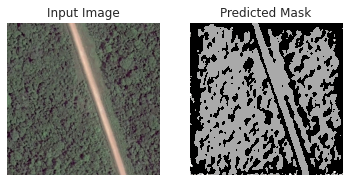

In [8]:
import torch
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
labels_cmap = matplotlib.colors.ListedColormap(["#000000", "#A9A9A9",
        "#8B8680", "#D3D3D3", "#FFFFFF"])

# Define the transformation to be applied to the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to match the input size of the model
    transforms.Grayscale(num_output_channels=3),  # Convert the image to grayscale
    transforms.ToTensor(),          # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize the image for grayscale
])

# Load the model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", classes=5).to(device)

# Load the trained model state dictionary
model.load_state_dict(torch.load("/kaggle/input/segmodel/model.pt", map_location=torch.device('cpu')))
model.eval()

# Load and preprocess the input image
image = Image.open("/kaggle/input/testing-image/WhatsApp Image 2024-02-10 at 13.51.31_efc7157e.jpg")
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
image_tensor = image_tensor.to(device)

# Perform inference
with torch.no_grad():
    output = model(image_tensor)

# Convert the output tensor to numpy array
output_np = output.cpu().numpy()

# Take argmax along the channel dimension to get the predicted class for each pixel
predicted_class = np.argmax(output_np, axis=1)[0]

# Visualize the input image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')  # Display grayscale image
plt.title("Input Image")
plt.axis('off')

# Visualize the predicted mask in shades of black and white
plt.subplot(1, 2, 2)
plt.imshow(predicted_class, cmap=labels_cmap)  # Use binary colormap for black and white
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt

# Define the transformation to be applied to the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to match the input size of the model
    transforms.ToTensor(),          # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Load the model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", classes=5).to(device)

# Load the trained model state dictionary
model.load_state_dict(torch.load("/kaggle/input/segmodel/model.pt", map_location=torch.device('cpu')))
model.eval()

# Load and preprocess the input image
image_path = "/kaggle/input/testing-image/WhatsApp Image 2024-02-10 at 13.51.31_efc7157e.jpg"
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
image_tensor = image_tensor.to(device)

# Perform inference
with torch.no_grad():
    output = model(image_tensor)

# Convert the output tensor to numpy array
output_np = output.cpu().numpy()

# Take argmax along the channel dimension to get the predicted class for each pixel
predicted_class = np.argmax(output_np, axis=1)[0]

# Visualize the input image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')

# Visualize the predicted mask with color-coded classes
plt.subplot(1, 2, 2)
plt.imshow(predicted_class, cmap='jet')  # Use 'jet' colormap for color-coded classes
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

## 3.4 DeepLabV3+ with Resnet encoder <a name="3.3"></a>

Now we try the state-of-the-art architecture on semantic segmentation - DeepLabV3+ [[3]](#ref3). Below you can see a visual representation of the architecture. 

<img src="https://github.com/ChrisNick92/Geospatial-Data/blob/main/Lab6/Images/deeplab.png?raw=true" width ="800" height = "600">
<br><br>

The atrous conv is the main operation of the model. It uses dilated convolution to capture the contextual information at multiple scales and it is really effective for high resolution images.

In [ ]:
model = smp.DeepLabV3Plus(encoder_name = "resnet50",
                         encoder_weights = "imagenet",
                         decoder_atrous_rates = (12,18,24),
                         encoder_output_stride =16,
                         classes = 5).to(device)

In [ ]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 5, verbose = True, model_title = "DeepLabV3+ with Resnet encoder", save = True,
             stopping_criterion = "loss")

In [ ]:
# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                        device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

In [ ]:
visualize_preds(model, test_set, title = "Predictions - DeepLabV3+",
               save_title = "DeepLabV3+", h = 12, w = 12, indices = [957,961,1476,1578])

In [ ]:
# Delete the output folder
from pathlib import Path
import shutil
OUTPUT_DIR = os.path.join(os.getcwd(), "output")

if Path(OUTPUT_DIR).exists():
    shutil.rmtree(OUTPUT_DIR)
    print(f"Delete {OUTPUT_DIR} directory successfully")

# References <a name="refs"></a>


[1] [LandCover.ai: Dataset for Automatic Mapping of Buildings, Woodlands, Water and Roads from Aerial Imagery](https://arxiv.org/abs/2005.02264) <a name="ref1"></a>

[2] [The VIA Annotation Software for Images, Audio and Video](https://arxiv.org/abs/1904.10699)  <a name="ref2"></a>

[3] [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1802.02611) <a name="ref3"></a>

[4] [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357) <a name="ref4"></a>

[5] [Deformable Convolutional Networks](https://arxiv.org/abs/1703.06211) <a name="ref5"></a>

[6] [Searching for Efficient Multi-Scale Architectures for Dense Image Prediction](https://arxiv.org/abs/1809.04184) <a name="ref6"></a>

[7] [TorchGeo: Deep Learning With Geospatial Data](https://arxiv.org/abs/2111.08872) <a name="ref7"></a>

[8] [Supervising Remote Sensing Change Detection Models with 3D Surface Semantics](https://arxiv.org/abs/2202.13251) <a name="ref8"></a>

[9] [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) <a name="ref9"></a>